# 0. Hamiltonians as circuits

# 1. Parametrized Circuits

### The circuit keeps such expressions symbolically until numerical values are assigned.
### This makes it easy to express relationships between parameters.

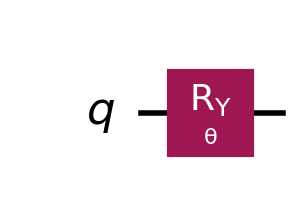

In [13]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

theta = Parameter("θ")
qc = QuantumCircuit(1)
qc.ry(theta, 0)

qc.draw(output='mpl', scale=2)

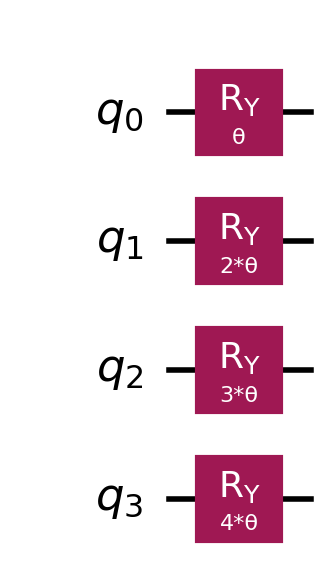

In [14]:
theta = Parameter("θ")
qc = QuantumCircuit(4)
qc.ry(theta, 0)
qc.ry(2*theta, 1)
qc.ry(3*theta, 2)
qc.ry(4*theta, 3)

qc.draw(output='mpl', scale=2)

Circuit with θ = π/4:
Bloch spheres for the four qubits:


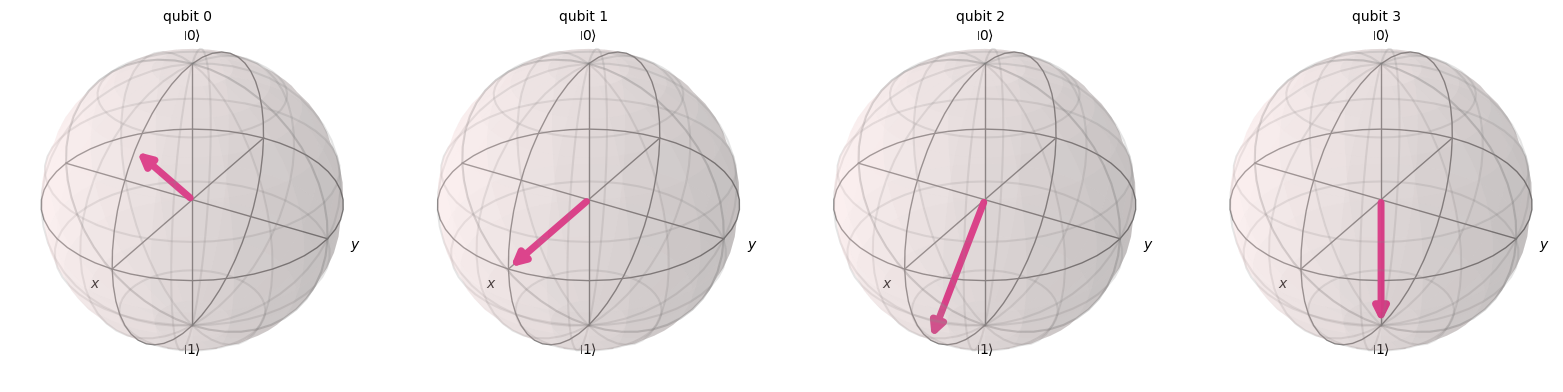

In [5]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import numpy as np

# Assign θ = π/4
theta_value = np.pi / 4
qc_bound_multi = qc.assign_parameters({theta: theta_value})


print(f"Circuit with θ = π/4:")
qc_bound_multi.draw(output="mpl")

# Get the statevector for the bound circuit
state = Statevector.from_instruction(qc_bound_multi)

# Plot Bloch spheres for each qubit
print("Bloch spheres for the four qubits:")
plot_bloch_multivector(state)

# 1.1 Parameter Expressions

<class 'qiskit._accelerate.circuit.ParameterExpression'> <class 'qiskit._accelerate.circuit.ParameterExpression'>


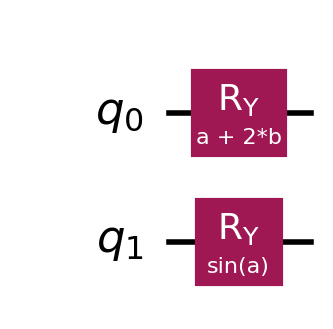

In [12]:
# Two base parameters
a = Parameter("a")
b = Parameter("b")

# Composite expression
theta_expr = a + 2 * b
sin_exp = np.sin(a)

print(type(theta_expr), type(sin_exp))

qc_exp = QuantumCircuit(2)

qc_exp.ry(theta_expr, 0)
qc_exp.ry(sin_exp, 1)

qc_exp.draw(output='mpl', scale=2)

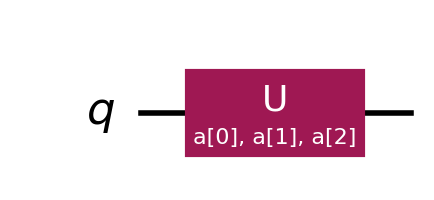

In [46]:
from qiskit.circuit import ParameterVector

param = ParameterVector("a", 3)
qc = QuantumCircuit(1)
qc.u(theta=param[0], phi=param[1], lam=param[2], qubit=0)
qc.draw("mpl", scale=2)

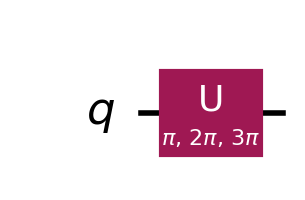

In [ ]:
qc_bound = qc.assign_parameters(parameters=[np.pi, 2*np.pi, 3*np.pi])
qc_bound.draw(output='mpl', scale=2)

# Important to note that assign_parameters() does not mutate the original circuit.
# You need to return a new circuit with the assigned parameter values

# 2. Toy VQE

We will start by applying VQE to a very simple case, to see how it works. We will compute the minimum eigenvalue of Pauli Z matrix with VQE.

We now define the operator of interest and view it in matrix form.

In [30]:
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp

# Pedagogical primitive that calculates using the statevector
sampler = StatevectorSampler() 
estimator = StatevectorEstimator()

op = SparsePauliOp("Z")
op.to_matrix()

array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])

It is easy to obtain the eigenvalues classically, so we can check our work. This might become difficult as we scale toward utility. Here we use numpy.

In [32]:
# compute eigenvalues with numpy
result = np.linalg.eigh(op.to_matrix())
print("Eigenvalues:", result.eigenvalues)

Eigenvalues: [-1.  1.]


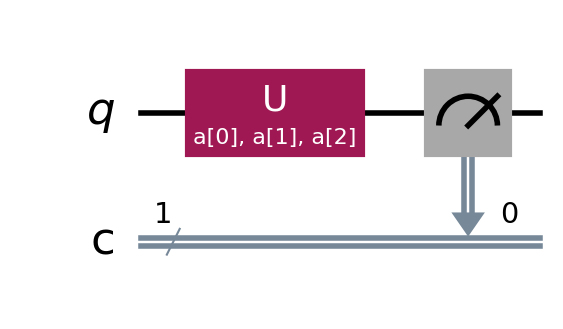

In [33]:
from qiskit.circuit import ParameterVector

param = ParameterVector("a", 3)
qc = QuantumCircuit(1, 1)
qc.u(theta=param[0], phi=param[1], lam=param[2], qubit=0)
qc_estimator = qc.copy()
qc.measure(0, 0)
qc.draw("mpl", scale=2)

In [27]:
result = sampler.run([(qc, [1, 2, 3])]).result()
counts = result[0].data.c.get_counts()
counts

{'0': 776, '1': 248}

In [28]:
# compute the expectation value of Z based on the counts
(counts.get("0", 0) - counts.get("1", 0)) / sum(counts.values())

0.515625

Note that Estimator takes quantum circuits without measurements.

In [31]:
result = estimator.run([(qc_estimator, op, [1, 2, 3])]).result()
result[0].data.evs

array(0.54030231)

This circuit worked, but the parameter values chosen did not correspond to a very low-energy (or low-eigenvalue) state. The eigenvalue obtained is quite a bit higher than the minimum. The result is similar when using estimator.

Note that Estimator takes quantum circuits without measurements.

# 3. Loss function

## We will need to search through parameters and find those that yield the lowest eigenvalue. We make a function to receive parameter values of the variational form and return the expectation value ⟨Z⟩

In [40]:
# define a cost function to look for the minimum eigenvalue of Z
loss = []
def cost(x):
    result = sampler.run([(qc, x)]).result()
    counts = result[0].data.c.get_counts()
    expval = (counts.get("0", 0) - counts.get("1", 0)) / sum(counts.values())
    loss.append(expval)
    # the following line shows the trajectory of the optimization
    print(expval, counts)
    return expval

### Apply Scipy's optimize function to find the minimum eigenvalue of Z

In [41]:
# minimize the cost function with scipy's minimize
from scipy.optimize import minimize

min_result = minimize(cost, [0, 0, 0], method="COBYLA", tol=1e-8)
min_result

1.0 {'0': 1024}
0.541015625 {'0': 789, '1': 235}
0.546875 {'0': 792, '1': 232}
0.529296875 {'0': 783, '1': 241}
-0.455078125 {'1': 745, '0': 279}
-0.63671875 {'1': 838, '0': 186}
-0.642578125 {'1': 841, '0': 183}
-0.484375 {'1': 760, '0': 264}
-0.080078125 {'0': 471, '1': 553}
-0.994140625 {'1': 1021, '0': 3}
-0.564453125 {'1': 801, '0': 223}
-0.984375 {'1': 1016, '0': 8}
-1.0 {'1': 1024}
-0.962890625 {'1': 1005, '0': 19}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-0.998046875 {'1': 1023, '0': 1}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-0.998046875 {'1': 1023, '0': 1}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-0.998046875 {'1': 1023, '0': 1}
-0.998046875 {'1': 1023, '0': 1}
-1.0 {'1': 1024}
-1.0 {'1': 1024}


 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -1.0
       x: [ 3.106e+00  1.408e-02  2.264e+00]
    nfev: 33
   maxcv: 0.0

In [42]:
result = sampler.run([(qc, min_result.x)]).result()
result[0].data.c.get_counts()

{'1': 1023, '0': 1}

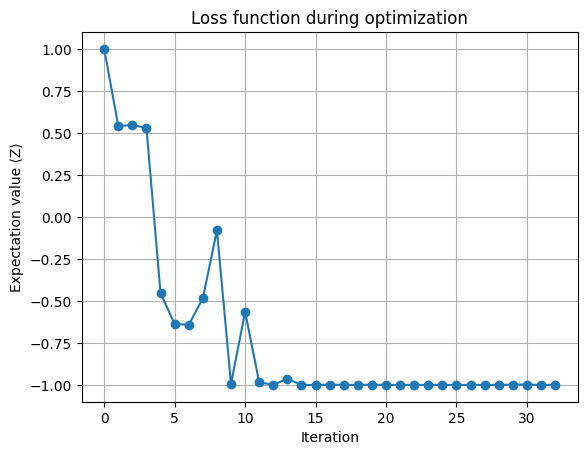

In [43]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Expectation value ⟨Z⟩")
plt.title("Loss function during optimization")
plt.grid(True)
plt.show()

## Exercise
### Compute the minimum eigenvalue of Z⊗Z with VQE.

In [38]:
z2 = SparsePauliOp("ZZ")
print(z2)
print(z2.to_matrix())

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


In [ ]:
# param = ParameterVector("a", D)
# qc = QuantumCircuit(n_qbit, n_cbit)

Eigenvalues of ZZ for each computational basis state

| Outcome | Z₀ | Z₁ | ZZ = Z₀·Z₁ |
| ------- | -- | -- | ---------- |
| `00`    | +1 | +1 | **+1**     |
| `01`    | +1 | −1 | **−1**     |
| `10`    | −1 | +1 | **−1**     |
| `11`    | −1 | −1 | **+1**     |


In [ ]:
# loss = []
# def cost(x):
#     result = sampler.run([(qc, x)]).result()
#     counts = result[0].data.c.get_counts()
#     expval = (
#         counts.get("00", 0)
#         - counts.get("01", 0)
#         - counts.get("10", 0)
#         + counts.get("11", 0)
#     ) / sum(counts.values())
#     loss.append(expval)
#     print(expval, counts)
#     return expval

In [ ]:
# minimize the cost function with scipy's minimize
# min_result = minimize(...)
# min_result

In [ ]:
# # check counts of bitstrings with the optimal parameters
# result = sampler.run([(qc, min_result.x)]).result()
# result[0].data.c.get_counts()

In [ ]:
# plt.figure()
# plt.plot(loss, marker="o")
# plt.xlabel("Iteration")
# plt.ylabel("Expectation value ⟨Z⟩")
# plt.title("Loss function during optimization")
# plt.grid(True)
# plt.show()